# DebriSolver CDM analysis and hybrid collision probability filter
# Short, clean notebook matching the journal paper.

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For optional parallel Monte Carlo over many events
from joblib import Parallel, delayed
from tqdm import tqdm

sns.set(style="whitegrid")

def existing_cols(cols, frame):
    return [c for c in cols if c in frame.columns]

# Paths and basic loading
DATA_PATH = "2024_S1_cdm_ccsds.csv"

df = pd.read_csv(DATA_PATH)
df.columns = df.columns.str.strip()

# Convert selected columns to numeric, keeping text/date columns as strings
NON_NUMERIC_COLS = [
    "comment_header", "creation_date", "originator", "message_id",
    "comment_relative_metadata_data", "tca", "start_screen_period",
    "stop_screen_period", "screen_volume_shape",
    "collision_probability_method", "collision_max_pc_method",
    "comment_object1_metadata", "object1_catalog_name", "object1_object_name",
    "object1_international_designator", "object1_object_type",
    "object1_ephemeris_name", "object1_covariance_method",
    "object1_orbit_center", "object1_ref_frame", "object1_cov_type",
    "comment_object1_od_parameters", "comment_object1_data_additional_parameters",
    "comment_object1_state_vector", "comment_object1_covmatrix",
    "comment_object2_metadata", "object2_catalog_name", "object2_object_name",
    "object2_international_designator", "object2_object_type",
    "object2_ephemeris_name", "object2_covariance_method",
    "object2_orbit_center", "object2_ref_frame", "object2_cov_type",
    "comment_object2_od_parameters", "comment_object2_data_additional_parameters",
    "comment_object2_state_vector", "comment_object2_covmatrix"
]

for col in df.columns:
    if col not in NON_NUMERIC_COLS:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Time columns
time_cols = ["creation_date", "tca", "start_screen_period", "stop_screen_period"]
for c in time_cols:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors="coerce")

# Drop columns that are completely empty
df = df.dropna(axis=1, how="all")

print("Total CDMs:", len(df))
print("Total columns after cleaning:", df.shape[1])

Total CDMs: 185511
Total columns after cleaning: 115


# Basic derived fields: geometry, altitude, and warning time
We will use these in most plots and tables.

In [17]:
# Combined hard-body radius (m)
df["hbr_total"] = df[["object1_hbr", "object2_hbr"]].sum(axis=1)

# Relative state magnitudes in RTN (m and m/s)
df["r_mag"] = np.sqrt(
    df["relative_position_r"]**2 +
    df["relative_position_t"]**2 +
    df["relative_position_n"]**2
)
df["v_mag"] = np.sqrt(
    df["relative_velocity_r"]**2 +
    df["relative_velocity_t"]**2 +
    df["relative_velocity_n"]**2
)

# Approach angle between r_rel and v_rel (deg)
dot_rv = (
    df["relative_position_r"] * df["relative_velocity_r"] +
    df["relative_position_t"] * df["relative_velocity_t"] +
    df["relative_position_n"] * df["relative_velocity_n"]
)
den_rv = df["r_mag"] * df["v_mag"]
cos_ang = np.clip(dot_rv / den_rv.replace(0, np.nan), -1.0, 1.0)
df["approach_angle_deg"] = np.degrees(np.arccos(cos_ang))

# Collision probability in log10 (clip to avoid -inf)
df["log_prob"] = np.log10(df["collision_probability"].clip(lower=1e-30))

# Altitude of object1 (km) using ECI position
if {"object1_x", "object1_y", "object1_z"}.issubset(df.columns):
    df["altitude_km"] = (
        np.sqrt(df["object1_x"]**2 + df["object1_y"]**2 + df["object1_z"]**2)
        - 6378.0
    )

# Warning time in hours
df["warning_hours"] = (df["tca"] - df["creation_date"]).dt.total_seconds() / 3600.0

# Keep only positive, reasonable warning times for ops analysis
df["warning_hours_clipped"] = df["warning_hours"].where(
    (df["warning_hours"] > 0) & (df["warning_hours"] < 200),
    np.nan
)

## Traffic profile and object-pair breakdown

object2_object_type  DEBRIS  PAYLOAD  ROCKET BODY  UNKNOWN
object1_object_type                                       
DEBRIS                22266     7943         2104      189
PAYLOAD                7548   132639         1561     2277
ROCKET BODY            2023     1307          249       59
UNKNOWN                 275     1792           89     3190

Traffic breakdown:
Payload vs Payload: 132639 (71.5 %)
Payload vs Debris/RB: 9109 (4.9 %)
Other pairs: 43763 (23.6 %)


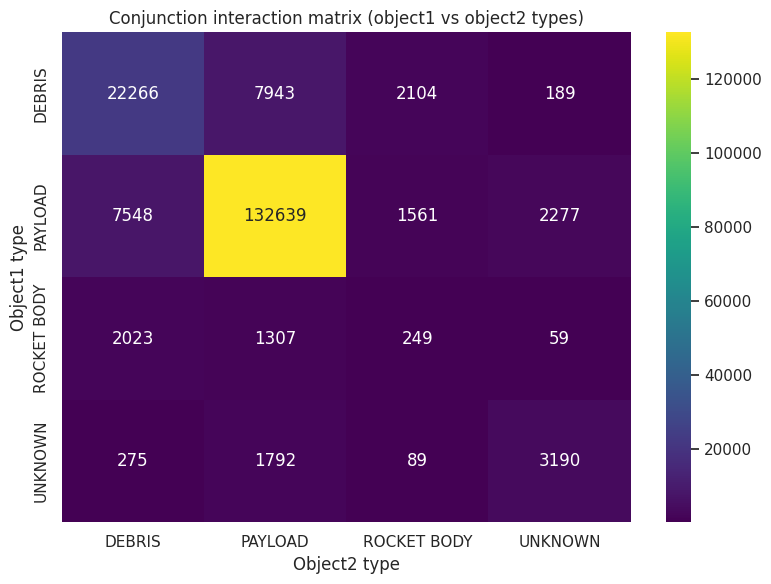

In [18]:
# Crosstab of object types
pair_matrix = pd.crosstab(df["object1_object_type"], df["object2_object_type"])
print(pair_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(pair_matrix, annot=True, fmt="d", cmap="viridis")
plt.title("Conjunction interaction matrix (object1 vs object2 types)")
plt.ylabel("Object1 type")
plt.xlabel("Object2 type")
plt.tight_layout()

# %%
# Simple three-class breakdown used for Table 1
is_payload1 = df["object1_object_type"] == "PAYLOAD"
is_payload2 = df["object2_object_type"] == "PAYLOAD"
is_debris_or_rb2 = df["object2_object_type"].isin(["DEBRIS", "ROCKET BODY"])

mask_pp = is_payload1 & is_payload2
mask_pj = is_payload1 & is_debris_or_rb2
mask_other = ~(mask_pp | mask_pj)

n_total = len(df)
n_pp = mask_pp.sum()
n_pj = mask_pj.sum()
n_other = mask_other.sum()

print("\nTraffic breakdown:")
print("Payload vs Payload:", n_pp, f"({100*n_pp/n_total:.1f} %)")
print("Payload vs Debris/RB:", n_pj, f"({100*n_pj/n_total:.1f} %)")
print("Other pairs:", n_other, f"({100*n_other/n_total:.1f} %)")


## Miss distance vs Pc and basic correlations



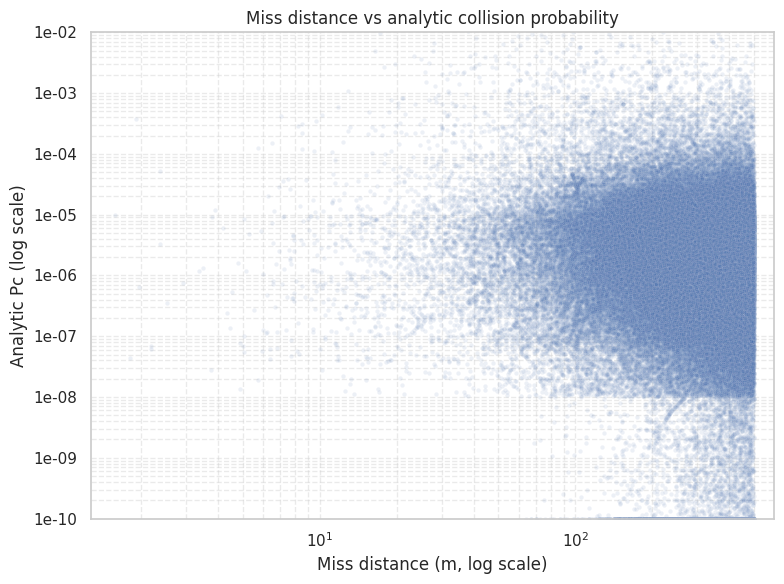

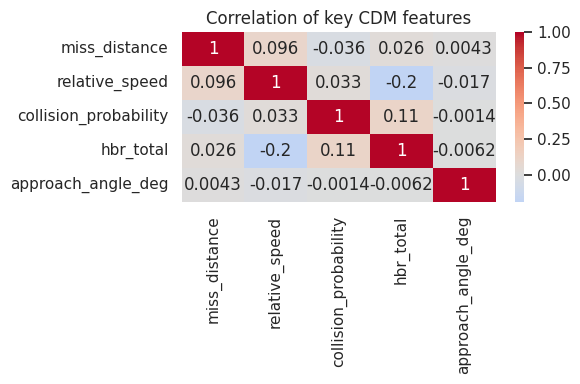

In [19]:
# Scatter: miss distance vs analytic Pc (log-log) ~ Figure 4 in paper
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df,
    x="miss_distance",
    y="collision_probability",
    alpha=0.1,
    s=10
)
plt.xscale("log")
plt.yscale("log")

yticks = np.logspace(-10, -2, 9)
plt.yticks(yticks, [f"{y:.0e}" for y in yticks])

plt.ylim(1e-10, 1e-2)
if df["miss_distance"].notna().any():
    plt.xlim(
        df["miss_distance"].min() * 0.8,
        df["miss_distance"].max() * 1.2
    )

plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.title("Miss distance vs analytic collision probability")
plt.xlabel("Miss distance (m, log scale)")
plt.ylabel("Analytic Pc (log scale)")
plt.tight_layout()

# %%
# Simple correlation matrix for key features ~ Figure 5 in paper
corr_cols = [
    "miss_distance", "relative_speed", "collision_probability",
    "hbr_total", "approach_angle_deg"
]
corr_cols = existing_cols(corr_cols, df)

corr = df[corr_cols].corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation of key CDM features")
plt.tight_layout()


 ## Encounter-plane geometry and analytic vs Monte Carlo Pc for a single event
 Here we build the encounter frame and 2D covariance used in both analytic and MC steps.


MC Pc ≈ 6.238e-02 from 50000 samples


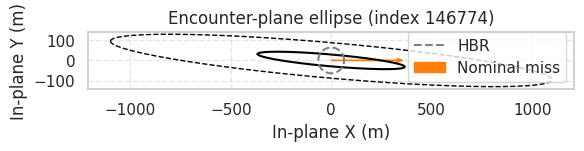

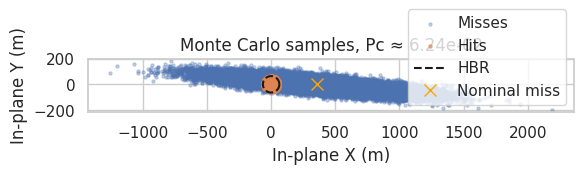

In [20]:
def relative_state_from_row(row):
    r_rel = np.array([
        row["relative_position_r"],
        row["relative_position_t"],
        row["relative_position_n"]
    ], dtype=float)
    v_rel = np.array([
        row["relative_velocity_r"],
        row["relative_velocity_t"],
        row["relative_velocity_n"]
    ], dtype=float)
    return r_rel, v_rel

def pos_cov_rtn_from_row(row, prefix):
    C = np.zeros((3, 3), float)
    C[0, 0] = row[f"{prefix}_cr_r"]
    C[1, 0] = C[0, 1] = row[f"{prefix}_ct_r"]
    C[1, 1] = row[f"{prefix}_ct_t"]
    C[2, 0] = C[0, 2] = row[f"{prefix}_cn_r"]
    C[2, 1] = C[1, 2] = row[f"{prefix}_cn_t"]
    C[2, 2] = row[f"{prefix}_cn_n"]
    return C

def combined_pos_cov(row):
    return pos_cov_rtn_from_row(row, "object1") + pos_cov_rtn_from_row(row, "object2")

def encounter_basis(r_rel, v_rel):
    vhat = v_rel / np.linalg.norm(v_rel)
    r_perp = r_rel - vhat * np.dot(r_rel, vhat)
    if np.linalg.norm(r_perp) < 1e-12:
        tmp = np.array([1.0, 0.0, 0.0]) if abs(vhat[0]) < 0.9 else np.array([0.0, 1.0, 0.0])
        r_perp = np.cross(vhat, np.cross(tmp, vhat))
    xhat = r_perp / np.linalg.norm(r_perp)
    yhat = np.cross(vhat, xhat)
    R = np.vstack([xhat, yhat, vhat])
    return R

def inplane_mean_cov_hbr(row):
    r_rel, v_rel = relative_state_from_row(row)
    C_rel = combined_pos_cov(row)
    R = encounter_basis(r_rel, v_rel)
    C3 = R @ C_rel @ R.T
    C2 = C3[:2, :2]
    mu2 = (R @ r_rel)[:2]
    hbr = float((row.get("object1_hbr", 0.0) or 0.0) +
                (row.get("object2_hbr", 0.0) or 0.0))
    return mu2, C2, hbr, R, r_rel, v_rel

def ellipse_axes(C2):
    vals, vecs = np.linalg.eigh(C2)
    order = np.argsort(vals)[::-1]
    vals = vals[order]
    vecs = vecs[:, order]
    sig_major = np.sqrt(max(vals[0], 0.0))
    sig_minor = np.sqrt(max(vals[1], 0.0))
    return sig_major, sig_minor, vals, vecs

# %%
def plot_encounter_plane(row, title="Encounter-plane ellipse at TCA"):
    mu2, C2, hbr, R, r_rel, v_rel = inplane_mean_cov_hbr(row)
    sig_major, sig_minor, vals, vecs = ellipse_axes(C2)

    theta = np.linspace(0, 2*np.pi, 256)
    circle = np.stack([np.cos(theta), np.sin(theta)])

    fig, ax = plt.subplots(figsize=(6, 6))
    for k, style in zip([1, 3], ["-", "--"]):
        scale = k
        ell = vecs @ np.diag(np.sqrt(vals)) @ circle * scale
        ax.plot(ell[0], ell[1], style, color="black", linewidth=1.5 if k == 1 else 1.0)

    # HBR circle
    ax.plot(hbr * np.cos(theta), hbr * np.sin(theta), "--", color="gray", label="HBR")

    # Miss vector
    ax.arrow(0, 0, mu2[0], mu2[1],
             head_width=0.05 * max(sig_major, sig_minor, hbr),
             length_includes_head=True,
             color="tab:orange",
             label="Nominal miss")

    ax.set_aspect("equal")
    ax.set_xlabel("In-plane X (m)")
    ax.set_ylabel("In-plane Y (m)")
    ax.set_title(title)
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.legend()
    plt.tight_layout()

# %%
# Choose one representative high-Pc case for geometry and MC plots
req_cols = [
    "relative_position_r", "relative_position_t", "relative_position_n",
    "relative_velocity_r", "relative_velocity_t", "relative_velocity_n",
    "object1_cr_r", "object1_ct_r", "object1_ct_t",
    "object1_cn_r", "object1_cn_t", "object1_cn_n",
    "object2_cr_r", "object2_ct_r", "object2_ct_t",
    "object2_cn_r", "object2_cn_t", "object2_cn_n",
    "object1_hbr", "object2_hbr",
    "collision_probability"
]
req_cols = existing_cols(req_cols, df)
subset_geom = df.dropna(subset=req_cols)

example_idx = subset_geom["collision_probability"].idxmax()
example_row = subset_geom.loc[example_idx]

plot_encounter_plane(example_row, title=f"Encounter-plane ellipse (index {example_idx})")

# %%
def mc_pc_encounter_plane(row, nsamp=100_000, seed=7, jitter=1e-12):
    mu2, C2, hbr, R, r_rel, v_rel = inplane_mean_cov_hbr(row)

    if not np.isfinite(hbr) or hbr <= 0.0:
        return {
            "Pc_mc": 0.0,
            "Pc_lo": 0.0,
            "Pc_hi": 0.0,
            "sigma_major": np.nan,
            "sigma_minor": np.nan,
            "angle_deg": np.nan
        }

    C2 = C2 + jitter * np.eye(2)
    try:
        L = np.linalg.cholesky(C2)
    except np.linalg.LinAlgError:
        w, V = np.linalg.eigh((C2 + C2.T) / 2.0)
        w = np.clip(w, 1e-16, None)
        C2 = V @ np.diag(w) @ V.T
        L = np.linalg.cholesky(C2 + jitter * np.eye(2))

    rng = np.random.default_rng(seed)
    z = rng.standard_normal((2, nsamp))
    samples = (L @ z) + mu2.reshape(2, 1)
    d2 = np.sum(samples**2, axis=0)
    hits = np.count_nonzero(d2 <= hbr * hbr)
    pc = hits / nsamp

    var = max(pc * (1.0 - pc), 1.0 / nsamp) / nsamp
    half = 1.96 * np.sqrt(var)
    lo = max(0.0, pc - half)
    hi = min(1.0, pc + half)

    w, _ = np.linalg.eigh(C2)
    w = np.sort(w)[::-1]
    sigma_major = np.sqrt(w[0])
    sigma_minor = np.sqrt(w[1])

    v_rel_plane = (R @ v_rel)[:2]
    num = float(np.dot(mu2, v_rel_plane))
    den = (np.linalg.norm(mu2) * np.linalg.norm(v_rel_plane) + 1e-12)
    angle_deg = float(np.degrees(np.arccos(np.clip(num / den, -1.0, 1.0))))

    return {
        "Pc_mc": pc,
        "Pc_lo": lo,
        "Pc_hi": hi,
        "sigma_major": sigma_major,
        "sigma_minor": sigma_minor,
        "angle_deg": angle_deg
    }

# %%
def demo_mc_hits(row, nsamp=100_000, seed=42):
    mu2, C2, hbr, R, r_rel, v_rel = inplane_mean_cov_hbr(row)
    rng = np.random.default_rng(seed)
    L = np.linalg.cholesky(C2 + 1e-12 * np.eye(2))
    z = rng.standard_normal((2, nsamp))
    samples = (L @ z) + mu2.reshape(2, 1)
    d2 = np.sum(samples**2, axis=0)
    inside = d2 <= hbr * hbr
    pc_est = inside.mean()

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(samples[0, ~inside], samples[1, ~inside], s=5, alpha=0.3, label="Misses")
    ax.scatter(samples[0, inside], samples[1, inside], s=5, alpha=0.6, label="Hits")

    theta = np.linspace(0, 2*np.pi, 256)
    ax.plot(hbr * np.cos(theta), hbr * np.sin(theta), "k--", label="HBR")

    ax.plot(mu2[0], mu2[1], "x", color="orange", markersize=8, label="Nominal miss")
    ax.set_aspect("equal")
    ax.set_xlabel("In-plane X (m)")
    ax.set_ylabel("In-plane Y (m)")
    ax.set_title(f"Monte Carlo samples, Pc ≈ {pc_est:.2e}")
    ax.legend()
    plt.tight_layout()

    print(f"MC Pc ≈ {pc_est:.3e} from {nsamp} samples")

# %%
demo_mc_hits(example_row, nsamp=50_000)

## Validity gates for analytic Pc and selection of events for Monte Carlo
 We implement size-ratio, tangency, and simple curvature gates.

In [21]:
MU_EARTH = 3.986004418e14  # m^3/s^2
R_EARTH = 6378e3           # m

def gating_metrics(row):
    mu2, C2, hbr, R, r_rel, v_rel = inplane_mean_cov_hbr(row)
    sig_major, sig_minor, vals, vecs = ellipse_axes(C2)

    # Size ratio: eta = R_HBR / sigma_minor
    eta = np.nan
    if sig_minor > 0 and np.isfinite(hbr):
        eta = hbr / sig_minor

    # Tangency metric: T = |cos(theta_app)| in the plane
    v_rel_plane = (R @ v_rel)[:2]
    num = float(np.dot(mu2, v_rel_plane))
    den = (np.linalg.norm(mu2) * np.linalg.norm(v_rel_plane) + 1e-12)
    T = abs(float(np.clip(num / den, -1.0, 1.0)))

    # Curvature metric: rho ≈ n * tau, tau ~ 2*sqrt(a*b)/|v|
    vmag = np.linalg.norm(v_rel)
    if vmag > 0 and sig_major > 0 and sig_minor > 0:
        a = sig_major
        b = sig_minor
        tau = 2.0 * np.sqrt(a * b) / vmag  # seconds
    else:
        tau = np.nan

    # Mean motion from object1 ECI position (if available)
    if {"object1_x", "object1_y", "object1_z"}.issubset(row.index):
        r1_km = np.sqrt(row["object1_x"]**2 + row["object1_y"]**2 + row["object1_z"]**2)
        r1_m = float(r1_km) * 1000.0
        if r1_m > 0:
            n = np.sqrt(MU_EARTH / (r1_m ** 3))
        else:
            n = np.nan
    else:
        n = np.nan

    rho = n * tau if (np.isfinite(n) and np.isfinite(tau)) else np.nan

    return eta, T, rho

# %%
# Apply gates on rows with full covariance and geometry info
gate_req = req_cols + ["object1_x", "object1_y", "object1_z"]
gate_req = existing_cols(gate_req, df)
gate_df = df.dropna(subset=gate_req).copy()

etas = []
Ts = []
rhos = []
for idx, row in gate_df.iterrows():
    eta, T, rho = gating_metrics(row)
    etas.append(eta)
    Ts.append(T)
    rhos.append(rho)

gate_df["eta"] = etas
gate_df["T_tangent"] = Ts
gate_df["rho_curv"] = rhos

# Physics red zone: analytic Pc > 1e-4
PHYSICS_RED_PC = 1e-4
gate_df["physics_red"] = gate_df["collision_probability"] > PHYSICS_RED_PC

# Monte Carlo candidates: red-zone or fail any gate
gate_df["fails_gate"] = (
    (gate_df["eta"] > 0.6) |
    (gate_df["T_tangent"] > 0.95) |
    (gate_df["rho_curv"] > 0.2)
)

gate_df["needs_mc"] = gate_df["physics_red"] | gate_df["fails_gate"]

n_red = gate_df["physics_red"].sum()
n_needs_mc = gate_df["needs_mc"].sum()
print("Physics red-zone events (analytic Pc > 1e-4):", n_red)
print("Events routed to MC (red or borderline):", n_needs_mc)

Physics red-zone events (analytic Pc > 1e-4): 2750
Events routed to MC (red or borderline): 65562


## Monte Carlo over the selected events and false-positive reduction

In [22]:
def mc_worker(row_dict, nsamp=100_000):
    # row_dict is a Series converted to dict for joblib
    row = pd.Series(row_dict)
    res = mc_pc_encounter_plane(row, nsamp=nsamp)
    return res["Pc_mc"]

# Convert subset to records for parallel run
mc_subset = gate_df[gate_df["needs_mc"]].copy()
print("MC subset size:", len(mc_subset))

mc_cols = existing_cols(
    req_cols + ["object1_x", "object1_y", "object1_z", "object1_hbr", "object2_hbr"],
    mc_subset
)
records = mc_subset[mc_cols].to_dict(orient="records")

mc_probs = Parallel(n_jobs=-1, backend="loky")(
    delayed(mc_worker)(rec) for rec in tqdm(records, desc="MC over candidates")
)

mc_subset["Pc_mc"] = mc_probs

# Merge back into main df
df["Pc_mc"] = np.nan
df.loc[mc_subset.index, "Pc_mc"] = mc_subset["Pc_mc"]

# %%
# Compare analytic vs MC high-risk events
MC_RED_PC = 1e-4
analytic_red = gate_df[gate_df["physics_red"]]
mc_red = mc_subset[mc_subset["Pc_mc"] > MC_RED_PC]

n_analytic_red = len(analytic_red)
n_mc_red = len(mc_red)
false_reduction = 100.0 * (1.0 - n_mc_red / max(n_analytic_red, 1))

print("Analytic red-zone events:", n_analytic_red)
print("MC-confirmed red-zone events:", n_mc_red)
print(f"False-positive reduction within red-zone: {false_reduction:.2f} %")

MC subset size: 65562


/tmp/ipython-input-3601979930.py:15: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  records = mc_subset[mc_cols].to_dict(orient="records")
MC over candidates: 100%|██████████| 65562/65562 [07:12<00:00, 151.64it/s]


Analytic red-zone events: 2750
MC-confirmed red-zone events: 2428
False-positive reduction within red-zone: 11.71 %


## Nightmare events and source breakdown
Nightmare events: MC Pc > 1e-4 and warning_hours < 24.

Total nightmare events: 530

Nightmare events by threat type:
object2_object_type
PAYLOAD        267
DEBRIS         207
ROCKET BODY     48
UNKNOWN          8
Name: count, dtype: int64


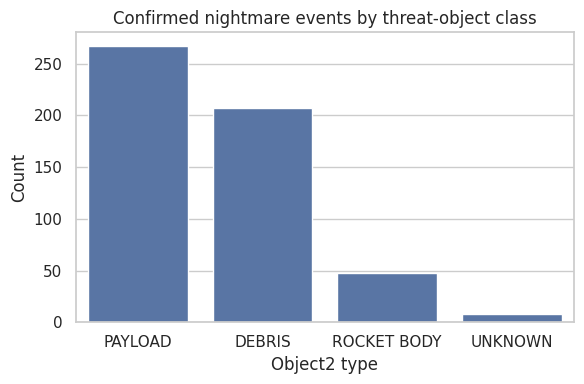

In [23]:
df["nightmare"] = (
    (df["Pc_mc"] > MC_RED_PC) &
    (df["warning_hours"] < 24.0) &
    (df["warning_hours"] > 0.0)
)

nightmare_df = df[df["nightmare"]].copy()
print("Total nightmare events:", len(nightmare_df))

# Breakdown by threat type (object2)
type_counts = nightmare_df["object2_object_type"].value_counts()
print("\nNightmare events by threat type:")
print(type_counts)

plt.figure(figsize=(6, 4))
sns.barplot(
    x=type_counts.index,
    y=type_counts.values
)
plt.title("Confirmed nightmare events by threat-object class")
plt.ylabel("Count")
plt.xlabel("Object2 type")
plt.tight_layout()

## Top threat objects (Table 2)
 We list the most frequent high-risk objects in the MC-confirmed set.

In [24]:
high_risk_df = df[df["Pc_mc"] > MC_RED_PC].copy()
top_objects = (
    high_risk_df["object2_object_name"]
    .value_counts()
    .head(10)
)
print("Top high-risk threat objects:")
print(top_objects)

Top high-risk threat objects:
object2_object_name
FENGYUN 1C DEB        192
DELTA 1 DEB            97
SL-8 R/B               87
NOAA 16 DEB            75
SHIYAN 24C 03          72
COSMOS 2251 DEB        56
TERRA SAR X            54
CZ-6A DEB              41
H-2A R/B               34
THORAD AGENA D DEB     33
Name: count, dtype: int64
